# Machine Learning Course Project
## Identifying User Stance On Social Media via Semi-Supervised Learning

### Overview

#### Midsem Pipeline - 

 - **Read Data**: Read text files to load all the words. 
 - **Clean Data**: Remove stop-words, everything lowercase, dehashify hashtags.
 - **Format Data**: Create data in a format required by each baseline method. 
 - **Baseline Approaches**: LSA, pLSA, Para2Vec, LDA Topic Modelling. The goal of these approaches is to create a "FIXED SIZE" and "HIGH LEVEL" feature representation for variable length tweets. These representations leverage our unlabelled data. 
 - **Training**: Some Supervised Learning on the learned representation using the given labels. 
 - **Evaluation**: Compare the different methods mentioned above on different datasets. 

#### Endsem Approaches - 
 - LDA2Vec - https://www.datacamp.com/community/tutorials/lda2vec-topic-model
 - Gaussian LDA - https://rajarshd.github.io/papers/acl2015.pdf
 - Word Embeddings Informed Topic Models - http://proceedings.mlr.press/v77/zhao17a/zhao17a.pdf
 
#### Reference
 - https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

## Constants

In [1]:
# PATH_LABELLED_DATA_TRAINING = "../semeval2016-task6-domaincorpus/data-all-annotations/trainingdata-all-annotations.txt"
PATH_LABELLED_DATA_TRUMP = "../semeval2016-task6-domaincorpus/data-all-annotations/testdata-taskB-all-annotations.txt"
PATH_UNLABELLED_DATA_TRUMP = "./../semeval2016-task6-domaincorpus/downloaded_Donald_Trump.txt"

## Data 

In [2]:
# SETUP
# # Run in python console
# import nltk; nltk.download('stopwords')

# # Run in terminal or command prompt
# !python -m spacy download en

In [3]:
# !pip install gensim
# !pip install pyLDAvis

In [4]:
import pandas as pd
import numpy as np
import re
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import LsiModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [5]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['via'])

### Read Sem-Eval Task A Data (Labelled)

Interactive Visualization - http://www.saifmohammad.com/WebPages/StanceDataset.htm

Targets - 
 - Hilary Clinton
 - Atheism
 - Climate Change
 - Donald Trump
 - Feminism
 - Abortion

### Remove Symbols

In [6]:
def clean_tweets(sent):
    sent = str(sent)
    
    # Remove new line characters
    sent = re.sub('\s+', ' ', sent)

    # Remove distracting single quotes
    sent = re.sub("\'", "", sent)

    # Remove distracting single quotes
    sent = re.sub("\"", "", sent)

    # Remove hashtags
    sent = re.sub("\#", "", sent)

    # Remove http:// links
    sent = re.sub('http:\/\/.*','', sent)

    # Remove https:// links
    sent = re.sub('https:\/\/.*','', sent)
    
    # Remove emojis
#     emoji_pattern = re.compile("["
#         u"\U0001F600-\U0001F64F"  # emoticons
#         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
#         u"\U0001F680-\U0001F6FF"  # transport & map symbols
#         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
#                            "]+", flags=re.UNICODE)
    
#     sent = emoji_pattern.sub(r'', sent)
    
    return sent
    

In [100]:
X_train = pd.read_pickle('X_train.pkl')
X_test = pd.read_pickle('X_test.pkl')
y_train = pd.read_pickle('y_train.pkl')
y_test = pd.read_pickle('y_test.pkl')

data_X = pd.concat([X_train, X_test], ignore_index=True, axis=0)
data_y = pd.concat([y_train, y_test], ignore_index=True, axis=0)
data_labelled = pd.concat([data_X, data_y], ignore_index=True, axis=1)
data_labelled.columns = ['Tweet', 'Stance']
# data_labelled = pd.DataFrame([data_labelled], columns = ['Tweet', 'Stance'])
# data_labelled = data_labelled.where(data_labelled.Target != np.nan)

#### Data Stats

In [106]:
data_labelled.where(data_labelled.Stance == 'AGAINST').count()

Tweet     299
Stance    299
dtype: int64

In [107]:
data_labelled.where(data_labelled.Stance == 'NONE').count()

Tweet     299
Stance    299
dtype: int64

In [108]:
data_labelled.where(data_labelled.Stance == 'FAVOR').count()

Tweet     299
Stance    299
dtype: int64

### Read Sem-Eval Task B Data (Unlabelled)

In [109]:
data_unlabelled = pd.read_csv(PATH_UNLABELLED_DATA_TRUMP, sep='\t', lineterminator='\n', encoding ='latin1', names = ["ID", "Tweet"])
data_unlabelled = data_unlabelled.where(data_unlabelled.Tweet != 'Not Available')
data_unlabelled.dropna(how='any', inplace=True)
data_unlabelled['Tweet'] = data_unlabelled['Tweet'].apply(lambda x: x[1:])
data_unlabelled['Tweet'] = data_unlabelled['Tweet'].apply(clean_tweets)
# data_unlabelled = data_unlabelled[:1000]
# data_unlabelled['Tweet'] = data_unlabelled['Tweet'].str.decode('latin1')

In [110]:
combined_data = pd.concat([data_unlabelled, data_labelled], ignore_index=True)

/Users/Sarthak/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


In [111]:
combined_data.count()

ID        53616
Stance      897
Tweet     54513
dtype: int64

In [112]:
combined_data.head(10)

,ID,Stance,Tweet
0,5.885112e+17,NaN,Dear DonaldTrump: Do you want to see HillaryCl...
1,5.888037e+17,NaN,Trump compares JebBush to liberal U.S. Preside...
2,5.891521e+17,NaN,Trump Lets His Followers Know HillaryClinton C...
3,5.891598e+17,NaN,"Donald Trump blows his trumpet once again, but..."
4,5.891884e+17,NaN,DonaldTrump spreads the message that HillaryCl...
5,5.891913e+17,NaN,Trump Lets His Followers Know HillaryClinton C...
6,5.893100e+17,NaN,Why we need feminism. everydaysexism DonaldTru...
7,5.893174e+17,NaN,DonaldTrump has to be the lowest form of scumb...
8,5.893454e+17,NaN,"Wow, this is a low and disgusting tweet! @real..."
9,5.893706e+17,NaN,\xe2\x80\x9c@Kon__K: Why we need feminism. eve...


In [113]:
df = combined_data['Tweet']
# df = data_labelled['Tweet']

In [114]:
data = df.values.tolist()
pprint(data[:1])

['Dear DonaldTrump: Do you want to see HillaryClinton s birth certificate too? '
 'If so, PLEASE FUCK OFF! UniteBlue LibCrib Hillary2016']


### Sentences To Words

In [115]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

pprint(data_words[:1])

[['dear',
  'donaldtrump',
  'do',
  'you',
  'want',
  'to',
  'see',
  'hillaryclinton',
  'birth',
  'certificate',
  'too',
  'if',
  'so',
  'please',
  'fuck',
  'off',
  'uniteblue',
  'libcrib',
  'hillary']]


### Create Bi-Grams Tri-Grams

In [116]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['dear', 'donaldtrump', 'do', 'you', 'want', 'to', 'see', 'hillaryclinton', 'birth_certificate', 'too', 'if', 'so', 'please', 'fuck', 'off', 'uniteblue_libcrib', 'hillary']


### Remove Stop Words and Lemmatize

WE NEED PRONOUNS FOR STANCE

In [117]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV', 'PRON']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [118]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV', 'PRON'])

print(data_lemmatized[:1]), print(len(data_lemmatized))

[['dear', 'donaldtrump', 'want', 'see', 'hillaryclinton', 'birth_certificate', 'fuck', 'uniteblue_libcrib', 'hillary']]
54513


(None, None)

## Format Data

In [119]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]]


In [120]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('birth_certificate', 1),
  ('dear', 1),
  ('donaldtrump', 1),
  ('fuck', 1),
  ('hillary', 1),
  ('hillaryclinton', 1),
  ('see', 1),
  ('uniteblue_libcrib', 1),
  ('want', 1)]]

In [121]:
len(id2word)

31211

## LDA

### Model 2

In [122]:
# !wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
# !unzip mallet-2.0.8.zip

In [123]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet('./mallet-2.0.8/bin/mallet', corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [124]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

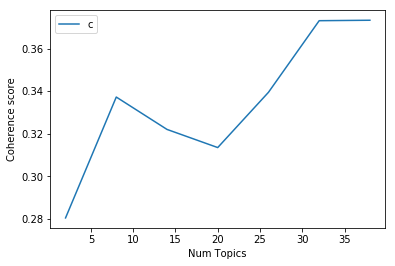

In [125]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [130]:
len(corpus)

54513

In [134]:
num_topics = x[np.argmax(coherence_values)]

In [135]:
num_topics

38

In [136]:
mallet_path = './mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
ldamallet = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)

In [137]:
from gensim.test.utils import datapath

# Save model to disk.
temp_file = datapath("lda-mallet-model-only-labelled-with-unlabelled-"+str(num_topics))
ldamallet.save(temp_file)

In [138]:
from gensim.test.utils import datapath

temp_file = datapath("lda-mallet-model-only-labelled-with-unlabelled-"+str(num_topics))
# Load a potentially pretrained model from disk.
ldamallet = gensim.models.ldamodel.LdaModel.load(temp_file)

In [139]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

[(34,
  [('president', 0.18569115563651084),
   ('run', 0.1206233555960332),
   ('donaldtrump', 0.11313499291641368),
   ('job', 0.07154422181744587),
   ('idiot', 0.025399716656547257),
   ('question', 0.020036429872495445),
   ('create', 0.018113742157458004),
   ('lose', 0.015179113539769277),
   ('answer', 0.014065978546852863),
   ('fail', 0.012649261283141065)]),
 (2,
  [('make', 0.24701156182637665),
   ('america', 0.19263178522437782),
   ('great', 0.10317460317460317),
   ('trump', 0.045071526553008036),
   ('china', 0.021262002743484224),
   ('save', 0.010973936899862825),
   ('happy', 0.010777973740936704),
   ('realdonaldtrump', 0.010582010582010581),
   ('strong', 0.010190084264158338),
   ('decision', 0.010190084264158338)]),
 (31,
  [('donaldtrump', 0.305041675137223),
   ('news', 0.06474893270990038),
   ('break', 0.02693636918072779),
   ('check', 0.018906281764586298),
   ('flag', 0.0178898150030494),
   ('report', 0.016263468184590364),
   ('americaferrera', 0.016161

### Topic Quality Inspection

#### Model 2

In [140]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.3639068012178567


## Evaluation

### Format Labelled Data

In [141]:
labelled_corpus = corpus[-897:]
len(labelled_corpus)

897

### Create Dataset for Supervised Learning

In [142]:
mallet_feats = []

for i in range(len(labelled_corpus)):
    representation = ldamallet.get_document_topics(labelled_corpus[i])
    count = 0
    feat = []
    for i in range(num_topics):
        if i in list(map((lambda x: x[0]), representation)):
            feat.append(representation[count][1])
            count = count + 1
        else:
            feat.append(0)
    mallet_feats.append(feat)

In [143]:
STANCES = ['AGAINST', 'FAVOR', 'NONE']

In [144]:
def transform_labels(label):
    if label == 'AGAINST':
        return 0
    elif label == 'FAVOR':
        return 1
    elif label == 'NONE':
        return 2

In [145]:
# labelled_stance = combined_data.Stance[53616:54323]
labelled_stance = data_labelled['Stance']
labelled_stance = labelled_stance.apply(transform_labels)
labelled_stance = labelled_stance.tolist()

In [146]:
len(mallet_feats[0]), len(mallet_feats)

(38, 897)

## Supervised Learning

In [147]:
from sklearn import svm
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
import argparse
from sklearn.utils.multiclass import unique_labels

In [152]:
## Create Train Test Split
X_train = mallet_feats[:627]
X_test = mallet_feats[627:]
y_train = labelled_stance[:627]
y_test = labelled_stance[627:]

In [155]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [159]:
def RandomForest(X_train, X_test, y_train, y_test):
    
    # GRID SEARCH
    parameters = {'n_estimators':range(100,600,100), 'max_depth':range(1,20,5)}
    rlf = RandomForestClassifier(random_state=0)
    rlf = GridSearchCV(rlf, parameters, cv=5)
    rlf.fit(X_train, y_train)
    
    y_pred = rlf.predict(X_test)

    rf_cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(y_test, y_pred, classes=STANCES,
                      title='Confusion matrix, without normalization')

    rf_cv = cross_val_score(rlf, X_train, y_train, cv=5, scoring='f1_macro')
    report = {}
    report["RF_cross_val_score"] = rf_cv.tolist()
    report["RF_mean_acc"] = rf_cv.mean()
    report["RF_std_acc"] = rf_cv.std()*2
    report["RF_params"] = rlf.cv_results_
    
    report["RF_CM"] = rf_cm.tolist()

    
    return report

In [166]:
def SVMClassifier(X_train, X_test, y_train, y_test):

    parameters = {'kernel':['linear','rbf','poly'], 'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
    
    clf = svm.SVC(gamma='auto')
    clf = GridSearchCV(clf, parameters, cv=5)
    clf.fit(X_train, y_train)
    
    clf_cv = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1_macro')
    report = {}
    report["SVM_cross_val_score"] = clf_cv.tolist()
    report["SVM_mean_acc"] = clf_cv.mean()
    report["SVM_std_acc"] = clf_cv.std()*2
    report["SVM_params"] = clf.cv_results_

    
    y_pred = clf.predict(X_test)

    clf_cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(y_test, y_pred, classes=STANCES,
                      title='Confusion matrix, without normalization')

    report["SVM_CM"] = clf_cm.tolist()

    
    return report
    

Confusion matrix, without normalization
[[59 16 13]
 [11 78  3]
 [ 4  1 85]]
{'RF_cross_val_score': [0.7914372576911276, 0.8067226322075935, 0.8103104212860309, 0.7696380451220035, 0.8250000000000001], 'RF_mean_acc': 0.8006216712613512, 'RF_std_acc': 0.03762695900515709, 'RF_params': {'mean_fit_time': array([0.12385054, 0.26124811, 0.40338745, 0.55271702, 0.75355678,
       0.22264524, 0.35891733, 0.50825162, 0.68251686, 0.93433399,
       0.19060736, 0.369104  , 0.57047491, 0.76528168, 1.03913975,
       0.20294261, 0.38315921, 0.63636827, 0.83117723, 1.06311307]), 'std_fit_time': array([0.01275505, 0.01562209, 0.04069109, 0.1188897 , 0.11607933,
       0.05337732, 0.03420073, 0.01261879, 0.03278556, 0.10073021,
       0.0099902 , 0.00441183, 0.02354999, 0.03682425, 0.06752637,
       0.00968865, 0.01304471, 0.09266276, 0.11465074, 0.12943244]), 'mean_score_time': array([0.00714173, 0.01577325, 0.02116857, 0.03071141, 0.04343491,
       0.01005526, 0.01555319, 0.02156444, 0.02837758, 

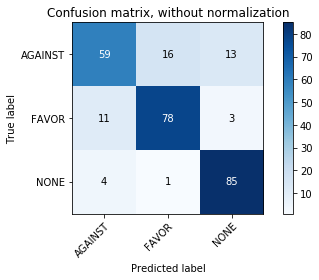

In [161]:
mallet_report = RandomForest(X_train, X_test, y_train, y_test)
print(mallet_report)

Confusion matrix, without normalization
[[48 21 19]
 [27 65  0]
 [20 17 53]]
{'SVM_cross_val_score': [0.7140784865282259, 0.5440725715573586, 0.6366753563963456, 0.6289388433966748, 0.6714126086718272], 'SVM_mean_acc': 0.6390355733100865, 'SVM_std_acc': 0.11244624501971957, 'SVM_params': {'mean_fit_time': array([0.0183847 , 0.0212595 , 0.01610837, 0.01462669, 0.02218709,
       0.01606526, 0.01572428, 0.02399116, 0.01546717, 0.01590805,
       0.02153616, 0.01900721, 0.0159647 , 0.0222291 , 0.01539102,
       0.01293426, 0.02157021, 0.01560411, 0.0154748 , 0.01920018,
       0.01615343]), 'std_fit_time': array([3.10320753e-03, 8.96971817e-04, 1.10303988e-03, 4.12077292e-04,
       4.64836838e-04, 3.97337294e-04, 2.46628393e-04, 4.68087032e-03,
       7.18843680e-05, 2.19196999e-03, 1.77944644e-03, 1.52791182e-03,
       7.47355556e-04, 3.52935298e-03, 2.29942210e-04, 4.29759932e-04,
       1.61876722e-03, 3.46003294e-04, 8.77390284e-04, 1.08929649e-03,
       9.72852451e-04]), 'mean_sc

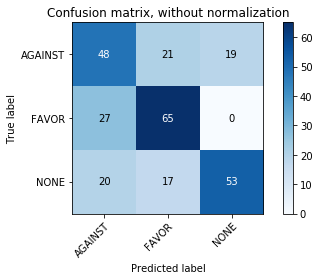

In [167]:
mallet_report = SVMClassifier(X_train, X_test, y_train, y_test)
print(mallet_report)